In [1]:
                                                                                # This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
#reading CSV with pandas
Taxonomy = pd.read_csv('../input/birdclef-2022/eBird_Taxonomy_v2021.csv')
test = pd.read_csv('../input/birdclef-2022/test.csv')
train_metadata = pd.read_csv('../input/birdclef-2022/train_metadata.csv')
submission = pd.read_csv('../input/birdclef-2022/sample_submission.csv')
from os import path
from pydub import AudioSegment
import seaborn as sns
from scipy.io.wavfile import read
from statsmodels.graphics.tsaplots import plot_acf
from scipy import signal
from scipy.io import wavfile


#transform into dataframe
df_taxonomy = pd.DataFrame(Taxonomy)

df_test = pd.DataFrame(test)

df_train = pd.DataFrame(train_metadata)

df_submission = pd.DataFrame(submission)

df_taxonomy.head()









,TAXON_ORDER,CATEGORY,SPECIES_CODE,PRIMARY_COM_NAME,SCI_NAME,ORDER1,FAMILY,SPECIES_GROUP,REPORT_AS
0,1,species,ostric2,Common Ostrich,Struthio camelus,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
1,6,species,ostric3,Somali Ostrich,Struthio molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN
2,7,slash,y00934,Common/Somali Ostrich,Struthio camelus/molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN
3,8,species,grerhe1,Greater Rhea,Rhea americana,Rheiformes,Rheidae (Rheas),Rheas,NaN
4,14,species,lesrhe2,Lesser Rhea,Rhea pennata,Rheiformes,Rheidae (Rheas),NaN,NaN


In [2]:
#opening the scored bird file
with open('../input/birdclef-2022/scored_birds.json','r') as f:
    data = json.load(f)
    

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


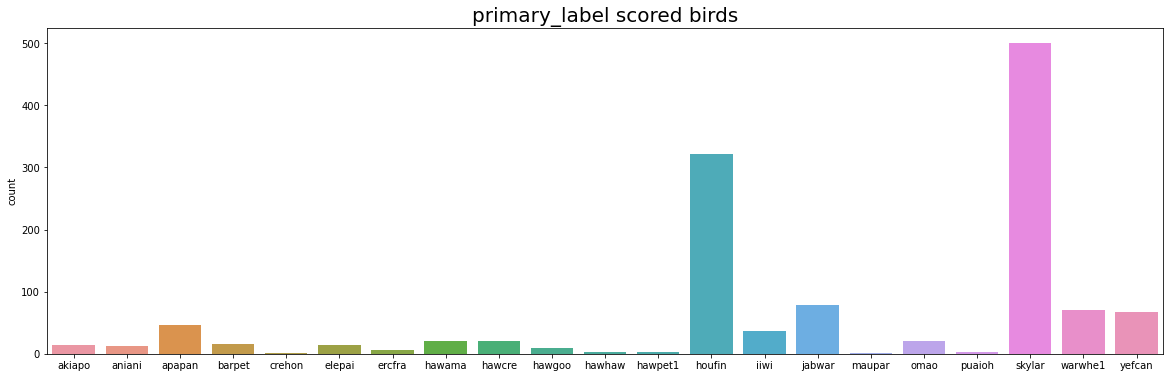

In [3]:
#let's check the primary_label of scored birds
index_row_scored = []
for i in data:
    a=i.strip('"')
    for j in range(len(df_train["primary_label"])):
        if df_train["primary_label"][j] == a:
            index_row_scored.append(j)

label_row_scored = []
for i in index_row_scored:
    label_row_scored.append(df_train["primary_label"][i])
    

plt.figure(figsize=(20, 6))
sns.countplot(label_row_scored)
plt.title("primary_label scored birds", fontsize=20)

plt.show()

In [4]:

from os import listdir
from os.path import isfile, join
rated_list = []
for i in data:
    onlyfiles = [f for f in listdir("../input/birdclef-2022/train_audio/"+i) if isfile(join("../input/birdclef-2022/train_audio/"+i,f))]
    rated_list.append(i)
    rated_list.append(onlyfiles)
    

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


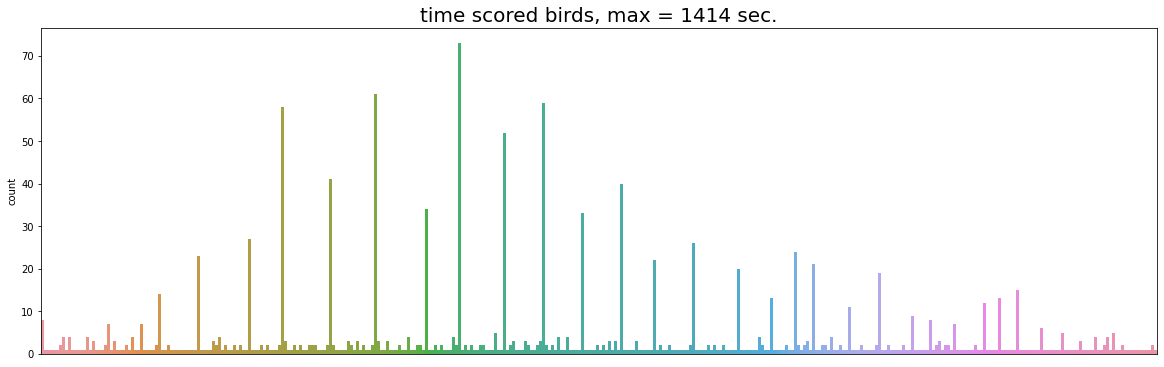

In [5]:
#Distribution of time of each scored audio
#Times goes from 0 to max(time_row_scored)=1414 sec.
counter = 0
time_row_scored = []
for i in index_row_scored:
    counter = counter +1
    if df_train["time"][i][0] not in ["?","x"] and df_train["time"][i][1] not in [":"]:
        time = int(df_train["time"][i][0])*10*60 + int(df_train["time"][i][1])*60 + int(df_train["time"][i][3])*10 +int(df_train["time"][i][4])
        time_row_scored.append(time)
    elif df_train["time"][i][0] not in ["?","x"]:
        time = int(df_train["time"][i][0])*60 + int(df_train["time"][i][2])*10 +int(df_train["time"][i][3])
        time_row_scored.append(time)
        
    
plt.figure(figsize=(20, 6))
sns.countplot(time_row_scored)
plt.title("time scored birds, max = 1414 sec.", fontsize=20)
plt.tick_params(axis = 'x', which = 'both', bottom = False,top = False, labelbottom = False )
plt.xticks(rotation=90)

plt.show()

In [6]:
#Let's calculate how many seconds of audio we have for each scored bird if possible and 
#let save it in a dictionary

counter = 0
time_row_scored = []
for i in index_row_scored:
    counter = counter +1
    if df_train["time"][i][0] not in ["?","x"] and df_train["time"][i][1] not in [":"]:
        time = int(df_train["time"][i][0])*10*60 + int(df_train["time"][i][1])*60 + int(df_train["time"][i][3])*10 +int(df_train["time"][i][4])
        time_row_scored.append(time)
    elif df_train["time"][i][0] not in ["?","x"]:
        time = int(df_train["time"][i][0])*60 + int(df_train["time"][i][2])*10 +int(df_train["time"][i][3])
        time_row_scored.append(time)
    else:
        time_row_scored.append(['Undefined'])


    

In [7]:
from collections import defaultdict
label_row_scored.sort()
outputlist = defaultdict(list)
for A, B in zip(label_row_scored, time_row_scored):
    outputlist[A].append(B)
time_scored_sum = []
for i in data:
    try:
        suma = sum(outputlist[i])
        time_scored_sum.append(suma)
    except:
        time_scored_sum.append(["?"])

In [8]:
dict_species_time = dict(zip(data,time_scored_sum))

In [9]:
dict_species_time

{'akiapo': 11671,
 'aniani': 8360,
 'apapan': 29820,
 'barpet': 18374,
 'crehon': 1157,
 'elepai': 9790,
 'ercfra': 2966,
 'hawama': 15575,
 'hawcre': 15832,
 'hawgoo': 7040,
 'hawhaw': 2373,
 'hawpet1': 3704,
 'houfin': ['?'],
 'iiwi': 23748,
 'jabwar': ['?'],
 'maupar': 738,
 'omao': 11694,
 'puaioh': 2010,
 'skylar': ['?'],
 'warwhe1': ['?'],
 'yefcan': ['?']}

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


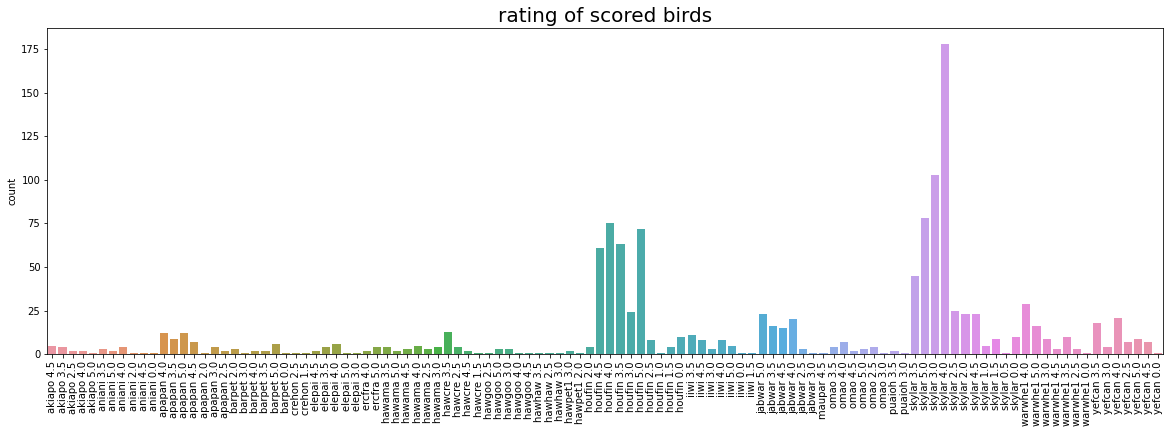

In [10]:
#we can try to find how many audios we have of each scored species and check the rating of
# them, for crehon for example, there are only 2 audios and with low quality.
scoredbird_rating = []
for i in index_row_scored:
    try:
        scoredbird_rating.append(str(df_train['primary_label'][i])+ " " +str(df_train['rating'][i]))
    except:
        print('error')
scoredbird_rating
plt.figure(figsize=(20, 6))
sns.countplot(scoredbird_rating)
plt.xticks(rotation=90)
plt.title("rating of scored birds", fontsize=20)

plt.show()


In [11]:
#the list with the indexes like line [80] is

indexes = [10,17,30,78,88,97,105,111,138,152,160,163,175,501,525,603,611,625,629,1129,1205]

In [12]:
#let's get our data from the dataframe
indexes_high_rate = []
for i in indexes:
    indexes_high_rate.append(index_row_scored[i])

    
    

[[ 17260  58119]
 [-60749 -29850]
 [-36259 -11703]
 ...
 [  3738  -1281]
 [ -8997 -17722]
 [ -4334 -12304]]


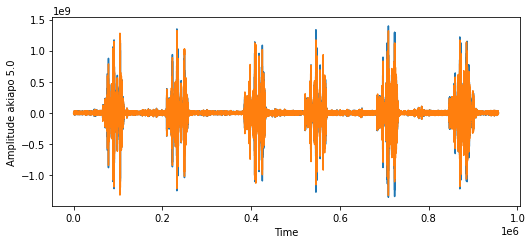

[[   927   9941]
 [-12454 -15278]
 [ 10030 -10508]
 ...
 [ -7186   9405]
 [-17542    569]
 [ -5080  17592]]


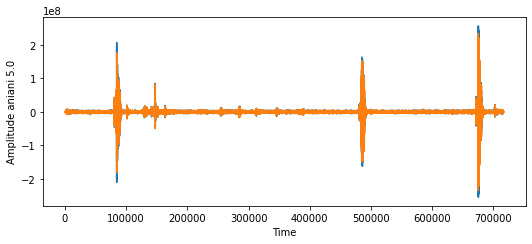

[ -1819   3848 -18640 ... -62915 275534 140544]


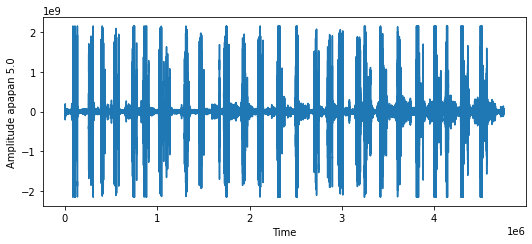

[  -16910   -62685      506 ... 13727468  9767640  7493745]


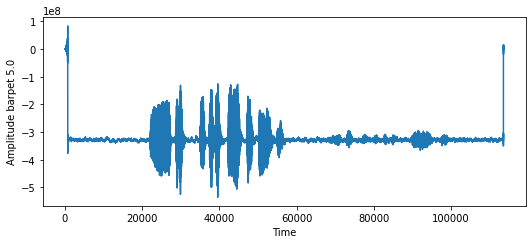

[[  -28242   -62231]
 [  -17075   -46525]
 [  -17517   -55595]
 ...
 [  -30218   482833]
 [-1587246 -1303263]
 [   82822  -854425]]


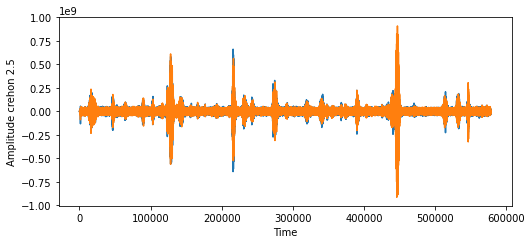

[-5854 -2758 59505 ... -6493  5115   748]


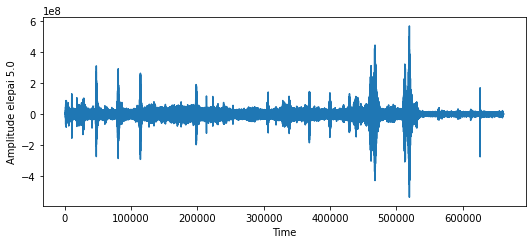

[[-36888  20135]
 [  5908  34487]
 [ 88668  86230]
 ...
 [  5860   9642]
 [  -939  -5628]
 [  -642  -3142]]


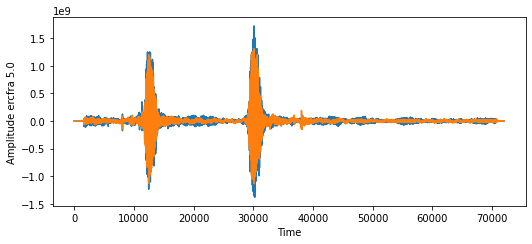

[ -3120  20545  -3630 ...   1816   9858 -13796]


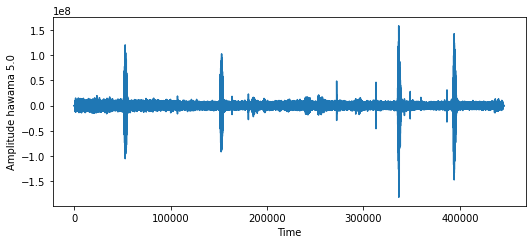

[[-46051 -27246]
 [ 14780  13572]
 [ -1965 -15538]
 ...
 [   308    135]
 [   -76    797]
 [  -123   1205]]


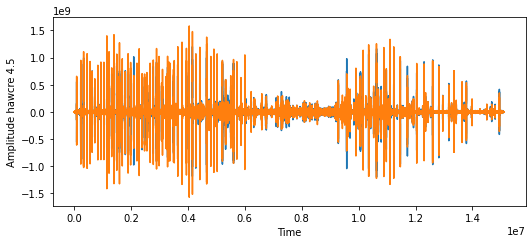

[[   9013    4313]
 [   5013   -9482]
 [  -1363  -27967]
 ...
 [2826039  825901]
 [3429432 1576045]
 [1403199 -399445]]


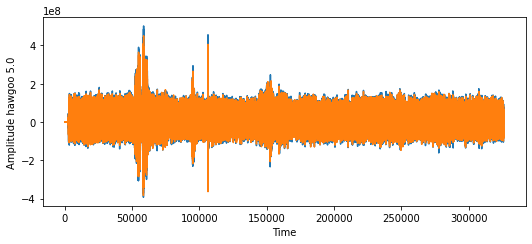

[[ 30256  48111]
 [-22352 -35788]
 [ -2534   -317]
 ...
 [  5456   9414]
 [  5102  32849]
 [ 10403  30032]]


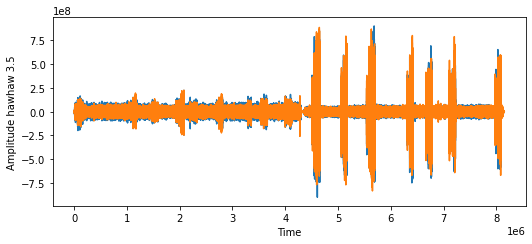

[-77143  -5196 -55581 ...  -1483   -996   -372]


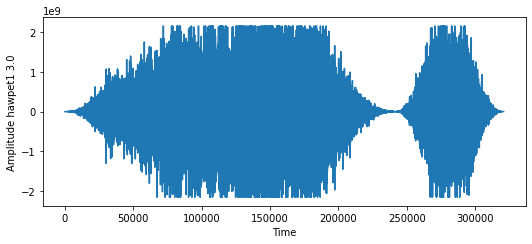

[[ 21564  62117]
 [  9933  47225]
 [-19661   2720]
 ...
 [  9767  21818]
 [ -8778   4490]
 [  -674  15847]]


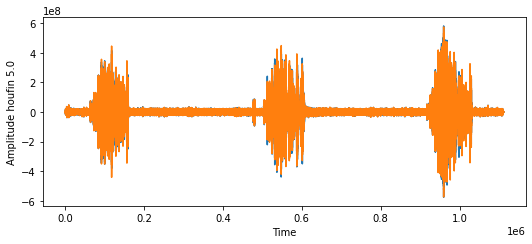

[ 49582   4498 -34531 ...      1     -1      0]


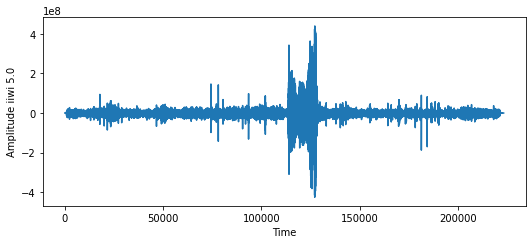

[[  1083 -16321]
 [-23526 -68767]
 [ 29227  -9179]
 ...
 [     2      1]
 [     0     -1]
 [     0      0]]


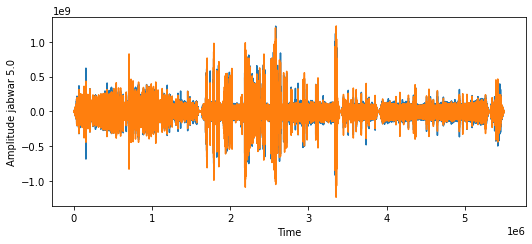

[[ 72769  63875]
 [  2107   5879]
 [-12801  -2098]
 ...
 [-33766 -13556]
 [ -9364  -2932]
 [ 12862  -3401]]


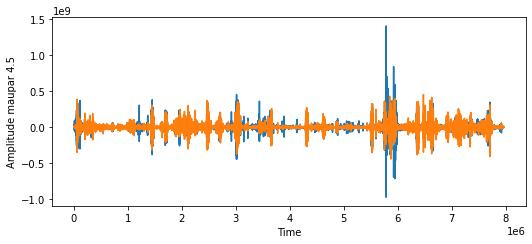

[-5848  2790 -8053 ...   529   194  -928]


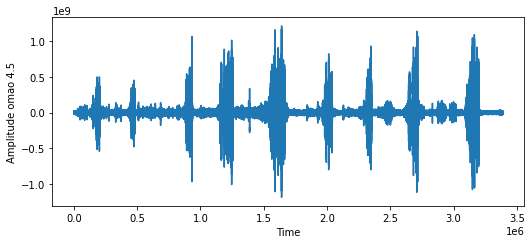

[-59009 -10108  -2232 ...  32570  40716  13963]


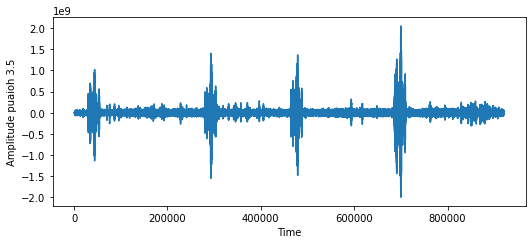

[-6839   613 -6308 ... -2638  2821  2334]


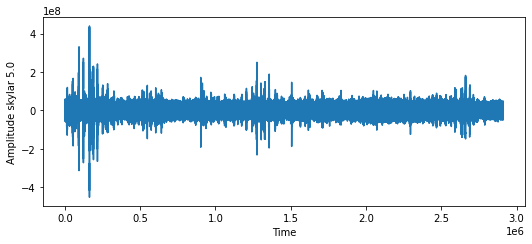

[-16663  70792   7037 ...  -8642  -1834   7962]


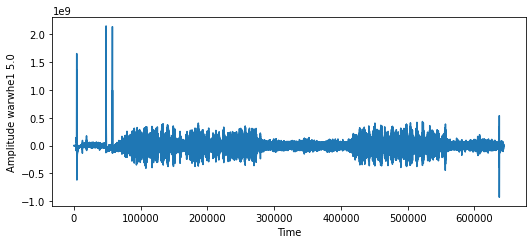

[[  19399   36068]
 [  26892   50328]
 [ -63071  -68410]
 ...
 [-276434 1853790]
 [-279332 1409572]
 [ 207900 1369016]]


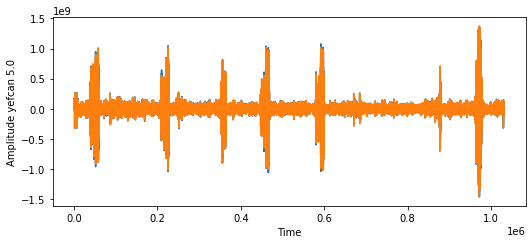

In [13]:
#Let's loop our first code with the random audio but for our list of rated birds
for i in indexes_high_rate:
    src = "../input/birdclef-2022/train_audio/" + str(df_train['filename'][i])
    dst = "/kaggle/working/" + str(df_train['primary_label'][i]) + ".wav"

# convert ogg to wav
    sound = AudioSegment.from_ogg(src)
    sound.export(dst, format="wav")
    
    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True
    input_data = read(dst)
    audio = input_data[1]
    print(audio)
    plt.plot(audio)
    plt.ylabel("Amplitude"+' ' +str(df_train['primary_label'][i]) + ' ' + str(df_train['rating'][i]))
    plt.xlabel("Time")
    plt.show()


In [14]:
#Let's do the same for all the audios
def features_extractor(file):
    #load the file (audio)
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    #we extract mfcc
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    #in order to find out scaled feature we do mean of transpose of value
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features


In [15]:
#We will use a dataframe with the scored birds just to see that everything works fine 
#without spending so much time
df_scored = df_train.copy()
for i in df_train.index:
    #if df_train['rating'][i]<2.5:
        #df_train.drop([i],axis = 0, inplace = True)
    if i not in index_row_scored:
        df_scored.drop([i],axis = 0, inplace = True)

In [16]:
#We will use a method that stract features from the audios
from tqdm import tqdm
# Now we iterate through every audio file and extract features 
# using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(df_scored.iterrows()):
    file_name = os.path.join(os.path.abspath("../input/birdclef-2022/train_audio/"),str(row["filename"]))
    final_class_labels=row["primary_label"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

1266it [13:34,  1.55it/s]


In [17]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','primary_label'])
extracted_features_df.head()

,feature,primary_label
0,"[-472.28574, 60.7976, -25.217098, 57.126324, 1...",akiapo
1,"[-446.27298, 55.930138, -19.547518, 57.774445,...",akiapo
2,"[-266.47318, 75.57892, -7.943713, 50.27808, -4...",akiapo
3,"[-404.56955, 26.65804, -27.88428, 29.090647, -...",akiapo
4,"[-381.15158, 27.375917, -63.842342, 60.094864,...",akiapo


In [18]:
#Now we split the data into train and test
from imblearn.over_sampling import RandomOverSampler #we improved accuracy with this!
oversample = RandomOverSampler(sampling_strategy='minority')
# Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['primary_label'].tolist())
# Label Encoding -> Label Encoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))
### Train Test Split
from sklearn.model_selection import train_test_split
#X,y = oversample.fit_resample(X, y)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.02)

In [19]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
trainedforest = RandomForestClassifier(n_estimators = 700).fit(X_train, y_train)
predictionforest = trainedforest.predict(X_test)
print(classification_report(y_test,predictionforest))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          12       1.00      0.29      0.44         7
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
X=np.array(extracted_features_df['feature'].tolist())
X_t = []
X__t = []
for j in range(0,40):
    X_t = []
    for i in range(len(X)):
        X_t.append(X[i][j])
    X__t.append(X_t)
    
feature_names = [f"feature {i}" for i in range(X.shape[1])]


<AxesSubplot:>

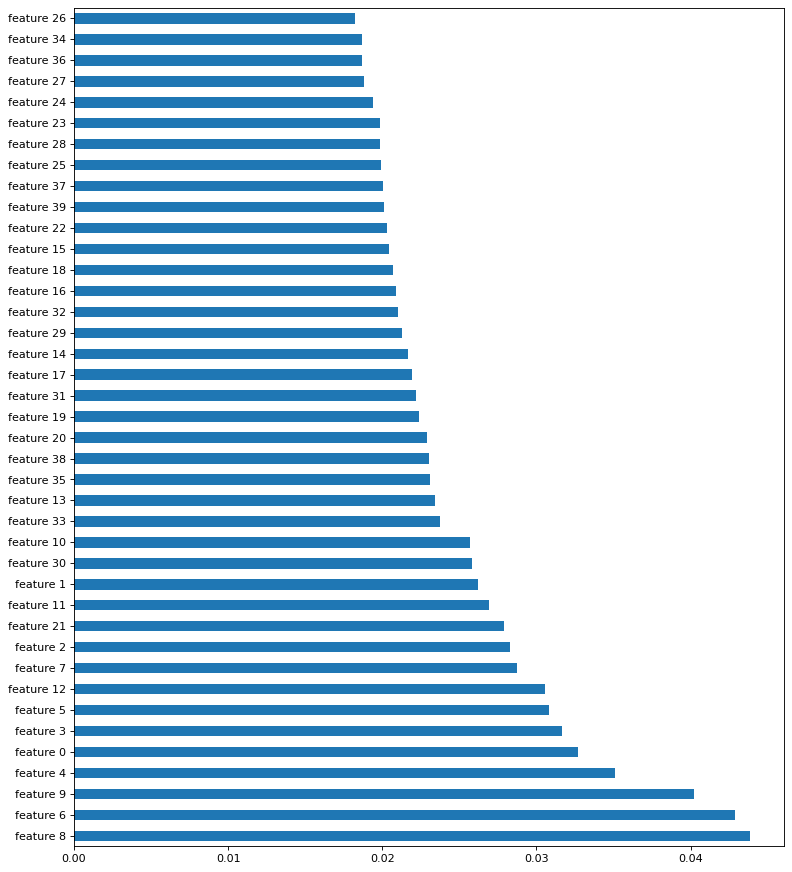

In [21]:
#Feature importance
from matplotlib.pyplot import figure
figure(num = None, figsize=(10,11), dpi = 80, facecolor = 'w', edgecolor = 'k')
feat_importances = pd.Series(trainedforest.feature_importances_, index = feature_names)
feat_importances.nlargest(40).plot(kind = 'barh')

<AxesSubplot:>

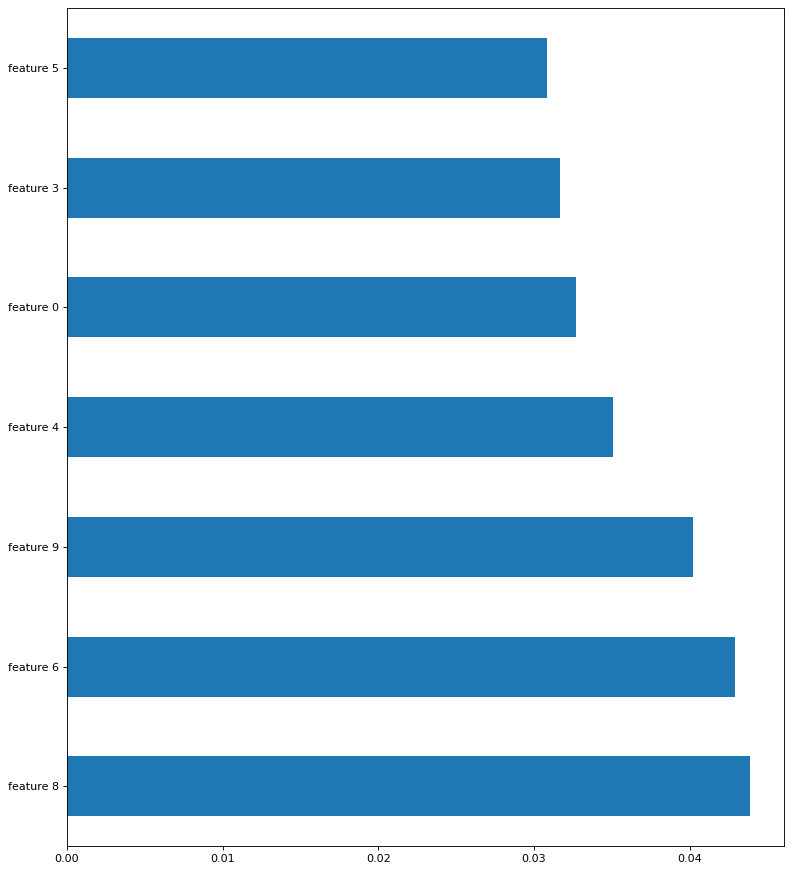

In [22]:


from matplotlib.pyplot import figure
figure(num = None, figsize=(10,11), dpi = 80, facecolor = 'w', edgecolor = 'k')
feat_importances = pd.Series(trainedforest.feature_importances_, index = feature_names)
feat_importances.nlargest(7).plot(kind = 'barh')

In [23]:
#We select the 7 features in our data
X_prueba = X
X_prueb = X_prueba.tolist()
X_pru = []
X_pri = []

for i in range(len(X)):
    for j in range(0,40):
        if j==6 or j==8 or j==9 or j==4 or j==0 or j==5 or j==12:
            X_pru.append(X_prueb[i][j])
    X_pri.append(X_pru)
    X_pru = []
            
                
X_pro = np.array([np.array(xi) for xi in X_pri])
print(X_pro)
len(X_pro)

[[-472.28573608   11.26227093   18.62749672 ...   -5.06986189
    17.48283386   -1.81247914]
 [-446.27297974   -4.24799156    7.91808462 ...   -8.31196499
    16.52576447   -3.09710312]
 [-266.47317505   -4.90197325   10.85512543 ...  -10.55334282
    13.49816227   -9.29772758]
 ...
 [-560.30517578  -56.60279083   -2.87694883 ...   -6.43454218
     5.96341133   -4.90424633]
 [-481.96133423  -31.65890312  -23.69248009 ...  -19.49150467
    -8.04002953   -9.09109688]
 [-461.07327271  -65.89056396   -0.76734853 ...  -15.94899559
    -5.16784239   -8.86606216]]


1266

In [24]:
X_train,X_test,y_train,y_test=train_test_split(X_pro,y,test_size=0.2)
X_train.shape
X_test.shape

(254, 7)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
# No of classes
num_labels=y.shape[1]

In [26]:

model=Sequential()
###first layer
model.add(Dense(100,input_shape=(7,)))
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('sigmoid'))
model.add(Dropout(0.5))
###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

2022-05-06 20:14:07.521102: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [27]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [28]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 
num_epochs = 200
num_batch_size = 32
checkpointer = ModelCheckpoint(filepath='./audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()
model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)

2022-05-06 20:14:11.169377: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
32/32 [==============================] - 1s 13ms/step - loss: 2.3961 - accuracy: 0.3014 - val_loss: 2.0302 - val_accuracy: 0.4213

Epoch 00001: val_loss improved from inf to 2.03016, saving model to ./audio_classification.hdf5
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 2.1375 - accuracy: 0.3340 - val_loss: 1.9767 - val_accuracy: 0.4213

Epoch 00002: val_loss improved from 2.03016 to 1.97667, saving model to ./audio_classification.hdf5
Epoch 3/200
32/32 [==============================] - 0s 6ms/step - loss: 2.0876 - accuracy: 0.3557 - val_loss: 1.9871 - val_accuracy: 0.4213

Epoch 00003: val_loss did not improve from 1.97667
Epoch 4/200
32/32 [==============================] - 0s 6ms/step - loss: 2.0653 - accuracy: 0.3567 - val_loss: 1.9765 - val_accuracy: 0.4213

Epoch 00004: val_loss improved from 1.97667 to 1.97651, saving model to ./audio_classification.hdf5
Epoch 5/200
32/32 [==============================] - 0s 6ms/step - loss: 2.0600 - ac

To fully understand what we are doing and change our code propperly we will make a little explanation

In [29]:
y = np.array(extracted_features_df['primary_label'].tolist())

In [30]:
y

array(['akiapo', 'akiapo', 'akiapo', ..., 'yefcan', 'yefcan', 'yefcan'],
      dtype='<U7')

we our dataset getting x and y being x the feature column and y the prymary label column

In [31]:
labelencoder.fit_transform(y)

array([ 0,  0,  0, ..., 20, 20, 20])

we trnasform into an array with the  names as numbers

In [32]:
y = to_categorical(labelencoder.fit_transform(y))

In [33]:
X = np.array(extracted_features_df['feature'].tolist())

In [34]:

# Let's check the accuracy!
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.5472440719604492


In [35]:
predict_x = model.predict(X_test)
classes_x = np.argmax(predict_x, axis = 1)
predict_x[1]

array([5.17239459e-05, 5.34936134e-03, 1.26874968e-02, 2.74022091e-02,
       1.60916452e-03, 8.56379513e-03, 2.99809937e-04, 3.08247004e-02,
       5.05272578e-03, 5.70100136e-02, 1.93473580e-03, 1.51218325e-02,
       3.84078361e-02, 2.02207025e-02, 2.13849008e-01, 2.71161957e-06,
       7.75614753e-03, 2.23963964e-03, 1.48060769e-01, 3.32042515e-01,
       7.15131387e-02], dtype=float32)

In [36]:
test_audio_dir = '../input/birdclef-2022/test_soundscapes/'
file_list = [f.split('.')[0] for f in sorted(os.listdir(test_audio_dir))]

In [37]:
with open('../input/birdclef-2022/scored_birds.json') as sbfile:
    scored_birds = json.load(sbfile)

In [38]:
pred = {'row_id': [], 'target': []}

In [39]:
# Process audio files and make predictions
for afile in file_list:
    
    # Complete file path
    path = test_audio_dir + afile + '.ogg'
    
    # Open file with librosa and split signal into 5-second chunks
    # sig, rate = librosa.load(path)
    # ...
    
    # Let's assume we have a list of 12 audio chunks (1min / 5s == 12 segments)
    chunks = [[] for i in range(12)]

In [40]:
chunks

[[], [], [], [], [], [], [], [], [], [], [], []]

In [41]:
# to check our prediction, those are the strings we need to compare:
a = 0
for i in range(len(y_test)):
    if str(y_test[i])==str(predict_x[i]).replace(".", ""):
        a=a+1
print(a)
print(a/len(y_test))

0
0.0


In [42]:
y_test.shape
predict_x.shape
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
#score = f1_score(str(y_test[1]),str(predict_x[1]).replace(".", ""), average = None)
#fil_acc_orig = accuracy_score(X_test,predict_x)

X_test

y



array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Let's prepare the test file to create the submision csv

In [43]:
# we will divide the test audio in 12 audios of 5 seconds.

from pydub import AudioSegment
from pydub.utils import make_chunks 
sound = AudioSegment.from_file("../input/birdclef-2022/test_soundscapes/soundscape_453028782.ogg")

chunk_length_ms = 5000 # pydub calculates in millisec 
chunks = make_chunks(sound,chunk_length_ms) #Make chunks of one sec 
for i, chunk in enumerate(chunks): 
    chunk_name = "{0}.ogg".format(i) 
    print ("exporting", chunk_name) 
    chunk.export(chunk_name, format="ogg") 


exporting 0.ogg
exporting 1.ogg
exporting 2.ogg
exporting 3.ogg
exporting 4.ogg
exporting 5.ogg
exporting 6.ogg
exporting 7.ogg
exporting 8.ogg
exporting 9.ogg
exporting 10.ogg
exporting 11.ogg


In [44]:
# Lets stract the features
import librosa
import numpy as np

def features_extractor(file):
    #load the file (audio)
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    #we extract mfcc
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    #in order to find out scaled feature we do mean of transpose of value
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features


import os
extracted_features_=[]
for i in range(0,12):
    file_name = os.path.join(os.path.abspath("./"),str(i) + ".ogg")
    data=features_extractor(file_name)
    extracted_features_.append([data])

In [45]:
import pandas as pd
extracted_features_df_=pd.DataFrame(extracted_features_,columns=['feature'])

In [46]:
X_=np.array(extracted_features_df_['feature'].tolist())
X_.shape

(12, 40)

In [47]:
X_prueba = X_
X_prueb = X_prueba.tolist()
X_pru = []
X_pri = []

for i in range(len(X_)):
    for j in range(0,40):
        if j==6 or j==8 or j==9 or j==4 or j==0 or j==5 or j==12:
            X_pru.append(X_prueb[i][j])
    X_pri.append(X_pru)
    X_pru = []
            
                
X_pro = np.array([np.array(xi) for xi in X_pri])
print(X_pro)
len(X_pro)

[[-2.68570679e+02  4.70512772e+00  3.21278267e+01 -1.25231256e+01
  -1.18632615e+00  2.94563313e+01  9.07198489e-02]
 [-2.72702209e+02  8.94261265e+00  3.13472729e+01 -1.08458481e+01
   9.88035917e-01  2.80058937e+01  1.94024754e+00]
 [-2.57900238e+02  2.91942954e+00  3.10720539e+01 -1.11971140e+01
  -2.63656330e+00  2.65794678e+01 -9.72614169e-01]
 [-2.72159210e+02  5.95474768e+00  2.95870686e+01 -8.96205902e+00
  -5.22896111e-01  2.67548599e+01  1.50386417e+00]
 [-2.80691986e+02  8.83075428e+00  3.10932579e+01 -7.29495478e+00
   1.49750245e+00  2.62910881e+01  1.86083746e+00]
 [-2.74872406e+02  5.19761133e+00  3.10166111e+01 -1.00028162e+01
   4.59903508e-01  2.81969223e+01  6.38194621e-01]
 [-2.79120972e+02  3.11973858e+00  3.01768780e+01 -1.11472731e+01
  -2.07206893e+00  2.92396030e+01 -9.34103370e-01]
 [-2.75581329e+02  2.34145832e+00  3.00929909e+01 -1.01638098e+01
  -1.47564411e+00  2.83575916e+01 -4.37796950e-01]
 [-2.70145905e+02  3.81017947e+00  3.10983391e+01 -1.05802002e+0

12

In [48]:
with open('../input/birdclef-2022/scored_birds.json') as sbfile:
    scored_birds = json.load(sbfile)

In [49]:
scored_birds_ = to_categorical(labelencoder.fit_transform(scored_birds))

In [50]:
score = []
scored_birds_.tolist()
predict_x.tolist()
for i in range(len(scored_birds_)):
    for j in range(len(predict_x)):
        if str(scored_birds_[i]).replace(".", "") == str(predict_x[j]).replace(".", ""):
            score.append(scored_birds[i])
print(score)


[]


In [51]:
predict__=model.predict(X_pro)

In [52]:
# This is where we will store our results
pred = {'row_id': [], 'target': []}

# Process audio files and make predictions
for afile in file_list:
    
    # Complete file path
    path = test_audio_dir + afile + '.ogg'
    
    # Open file with librosa and split signal into 5-second chunks
    # sig, rate = librosa.load(path)
    # ...
    
    # Let's assume we have a list of 12 audio chunks (1min / 5s == 12 segments)
    chunks = [[] for i in range(12)]
    
    # Make prediction for each chunk
    # Each scored bird gets a random value in our case
    # since we don't actually have a model
    for i in range(len(chunks)):        
        chunk_end_time = (i + 1) * 5
        j=0
        for bird in scored_birds:
            
            # This is our random prediction score for this bird
            score = predict__[i][j]
            j=j+1
            # Assemble the row_id which we need to do for each scored bird
            row_id = afile + '_' + bird + '_' + str(chunk_end_time)
            
            # Put the result into our prediction dict and
            # apply a "confidence" threshold of 0.5
            pred['row_id'].append(row_id)
            pred['target'].append(True if score > 0.5 else False)

In [53]:
from sklearn.ensemble import RandomForestClassifier

cls = RandomForestClassifier(random_state=0)
cls.fit(X_train, y_train)

z = cls.predict_proba(X_test)

In [54]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [55]:


predict_prob=model.predict(X_test)

predict_classes=np.argmax(predict_prob,axis=1)

predict_prob

clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5))

In [56]:
y_train_ = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]
y_train_ = np.asarray(y_train_)
y_train_.shape
X_train.shape
k=np.array(extracted_features_df['primary_label'].tolist())
k = labelencoder.fit_transform(k)

In [57]:
clf.fit(X, k)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=0, tol=1e-05))])

In [58]:
pre = clf.score(X,k)

In [59]:
prediction = clf.decision_function(X)

In [60]:
results = pd.DataFrame(pred, columns = ['row_id', 'target'])

# Quick sanity check
print(results.head()) 
    
# Convert our results to csv
results.to_csv("submission.csv", index=False)

                          row_id  target
0  soundscape_453028782_akiapo_5   False
1  soundscape_453028782_aniani_5   False
2  soundscape_453028782_apapan_5   False
3  soundscape_453028782_barpet_5   False
4  soundscape_453028782_crehon_5   False
